In [1]:
#hide
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json

api_token = {"username":"nitinkashyap","key":"b0a54ce5183e803af6428bfa11d5c539"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-jun-2021

  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 28.3MB/s]
  0% 0.00/3.14M [00:00<?, ?B/s]
100% 3.14M/3.14M [00:00<00:00, 103MB/s]
 77% 5.00M/6.49M [00:00<00:00, 43.6MB/s]
100% 6.49M/6.49M [00:00<00:00, 41.4MB/s]


In [2]:
!pip install optuna
!pip install catboost

!pip install shap

from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

import pandas as pd
from sklearn.model_selection import train_test_split

from catboost import Pool, CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns
import catboost
import optuna
import shap

     |████████████████████████████████| 296kB 9.1MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 174kB 16.8MB/s 
     |████████████████████████████████| 143kB 18.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 112kB 18.7MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=b0ba9ebcda84cd6a0cb339c80136d5d1e2b99423b5a405a087d65cb0de5a99d7
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip
     |████████████████████████████████| 69.2MB 63kB/s 
     |████████████████████████████████| 358kB 7.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491631 sha256=c34038c4fe2f77d6a42962a2ca5d05e1bba2c2f5a67ff7a8963b97a975abe0e6
  Stored in directory: /root/.cache/pip/wheels/15/27/

In [3]:

train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
sample_submission = pd.read_csv('sample_submission.csv.zip')

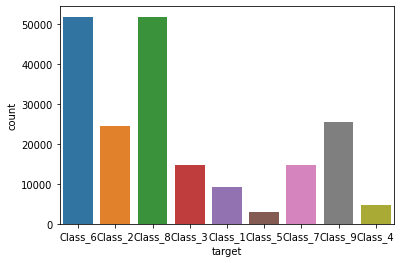

In [4]:
sns.countplot(x='target', data=train)

In [5]:
train.target = pd.Categorical(train.target)
train['target2'] = train.target.cat.codes

In [6]:
indep_vars = ['feature_' + str(i) for i in range(75)]
dep_var = ['target2']

In [5]:
def train_models(df, columns, cat_features, random_state, n_splits):

    models = []
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True,
                            random_state=random_state)  # create folds
    X_train = df[columns]
    y_train = df['target']
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,  y_train)):
        print('Fold {}/{}'.format(n_fold, n_splits))
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        dataset = Pool(train_X, train_y, cat_features)
        evalset = Pool(valid_X, valid_y, cat_features)
        model = CatBoostClassifier(
            task_type="GPU",
            depth=4,
            max_ctr_complexity=15,
            # border_count=1024,
            iterations=50000,
            od_wait=1000, od_type='Iter',
            # l2_leaf_reg=0.01,
            learning_rate=0.01,
            min_data_in_leaf=1,
            use_best_model=True,
            loss_function='MultiClass'

        )
        model.fit(dataset, plot=False, verbose=500, eval_set=evalset)        
        _record = {
            'model': model,
        }
        models.append(_record)

    return models

In [7]:
train.shape[0]/10

20000.0

In [ ]:
models = train_models(df=train, columns=indep_vars, cat_features=indep_vars, random_state=43, n_splits=20)

In [ ]:
train.groupby('target').count()['id']*100/train.shape[0]

target
Class_1     4.5590
Class_2    12.2155
Class_3     7.3990
Class_4     2.3520
Class_5     1.5320
Class_6    25.9055
Class_7     7.3845
Class_8    25.8815
Class_9    12.7710
Name: id, dtype: float64

In [ ]:
X_test = test[indep_vars]

In [ ]:
def submissionFile(modelZ, generate_csv=True):  # 4d 
    probabilities = pd.DataFrame(modelZ.predict_proba(X_test), columns=['Class_1','Class_2','Class_3','Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
    mySubmission = pd.DataFrame()
    mySubmission['id'] = test['id']
    mySubmission['Class_1'] = probabilities['Class_1']
    mySubmission['Class_2'] = probabilities['Class_2']
    mySubmission['Class_3'] = probabilities['Class_3']
    mySubmission['Class_4'] = probabilities['Class_4']
    mySubmission['Class_5'] = probabilities['Class_5']
    mySubmission['Class_6'] = probabilities['Class_6']
    mySubmission['Class_7'] = probabilities['Class_7']
    mySubmission['Class_8'] = probabilities['Class_8']
    mySubmission['Class_9'] = probabilities['Class_9']
    
    if generate_csv:
        mySubmission.to_csv('submission.csv', index=False)
    return mySubmission

In [ ]:
#models[2]['model'].predict_proba(X_train)
submissionFile(models[3]['model'])
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f submission.csv -m "Sample-May-Pipeline"

100% 17.9M/17.9M [00:00<00:00, 36.3MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021

### Hyper parameter tuning using Optuna

In [6]:
train.columns

Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',
   

In [7]:
X=train.drop(['target','id'],axis=1)
Y=train['target']

In [8]:
def objective(trial,data=X,target=Y):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 7000, 25000),
            'od_wait':trial.suggest_int('od_wait', 1500, 3000),
            'loss_function':'MultiClass',
            'task_type':"GPU",
            'eval_metric':'MultiClass',
            'leaf_estimation_method':'Newton',
            'bootstrap_type': 'Bernoulli',
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',50,100),
            'subsample': trial.suggest_uniform('subsample',0,1),
            'random_strength': trial.suggest_uniform('random_strength',18,30),
            'depth': trial.suggest_int('depth',3,6),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',10,30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',2,6),
                }
    model = CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], early_stopping_rounds=150, verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [11]:
OPTUNA_OPTIMIZATION = True


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-06-04 13:56:01,626] A new study created in memory with name: no-name-11a957b3-bf1f-4ddc-bbaa-085b40a251e6
[I 2021-06-04 13:56:16,708] Trial 0 finished with value: 1.747574054379512 and parameters: {'iterations': 9138, 'od_wait': 2951, 'learning_rate': 0.060088992478719135, 'reg_lambda': 63.83231172408223, 'subsample': 0.8297216542624329, 'random_strength': 20.412995811833007, 'depth': 3, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 1.747574054379512.
[I 2021-06-04 13:56:25,746] Trial 1 finished with value: 1.7469365683946372 and parameters: {'iterations': 11659, 'od_wait': 2751, 'learning_rate': 0.09116546120264182, 'reg_lambda': 90.48196994660007, 'subsample': 0.8819226765658267, 'random_strength': 20.91635988945401, 'depth': 5, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 5}. Best is trial 1 with value: 1.7469365683946372.
[I 2021-06-04 13:56:36,309] Trial 2 finished with value: 1.7461133530245008 and parameters: {'iterations'

Number of finished trials: 40
Best trial: score 1.7449118083828137, params {'iterations': 18229, 'od_wait': 1856, 'learning_rate': 0.01182685825264699, 'reg_lambda': 99.81127440206066, 'subsample': 0.6018602826185804, 'random_strength': 23.638367505959724, 'depth': 6, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 2}


In [12]:
if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))

In [16]:
from sklearn.model_selection import StratifiedKFold

cat_params = study.best_trial.params
cat_params['loss_function'] = 'MultiClass'
cat_params['eval_metric'] = 'MultiClass'
cat_params['bootstrap_type']= 'Bernoulli'
cat_params['leaf_estimation_method'] = 'Newton'
cat_params['random_state'] = 42
cat_params['task_type']='GPU'
test_preds=None

splits_num = 20

kf = StratifiedKFold(n_splits = splits_num , shuffle = True , random_state = 42)
for fold, (tr_index , val_index) in enumerate(kf.split(X.values , Y.values)):
    
    print("-" * 50)
    print(f"Fold {fold + 1}")
    
    x_train,x_val = X.values[tr_index] , X.values[val_index]
    y_train,y_val = Y.values[tr_index] , Y.values[val_index]
        
    eval_set = [(x_val, y_val)]
    
    model =CatBoostClassifier(**cat_params)
    model.fit(x_train, y_train, eval_set = eval_set, verbose = False)
    
    train_preds = model.predict(x_train)    
    val_preds = model.predict_proba(x_val)
    
    print(log_loss(y_val, val_preds))
    
    if test_preds is None:
        test_preds = model.predict_proba(test[indep_vars].values)
    else:
        test_preds += model.predict_proba(test[indep_vars].values)

print("-" * 50)
test_preds /= splits_num

--------------------------------------------------
Fold 1


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

1.7537851466073844
--------------------------------------------------
Fold 2
1.7467450251802126
--------------------------------------------------
Fold 3
1.7461512014840241
--------------------------------------------------
Fold 4
1.7503984039596394
--------------------------------------------------
Fold 5
1.7390393271019806
--------------------------------------------------
Fold 6
1.7424718739090814
--------------------------------------------------
Fold 7
1.7482209036293643
--------------------------------------------------
Fold 8
1.734995032552186
--------------------------------------------------
Fold 9
1.7418908617538365
--------------------------------------------------
Fold 10
1.7443482847465885
--------------------------------------------------
Fold 11
1.7423977763538903
--------------------------------------------------
Fold 12
1.7472376686073774
--------------------------------------------------
Fold 13
1.7417535437798688
--------------------------------------------------
Fol

In [27]:
y_train

['Class_6', 'Class_6', 'Class_2', 'Class_8', 'Class_2', ..., 'Class_6', 'Class_6', 'Class_8', 'Class_7', 'Class_8']
Length: 199600
Categories (9, object): ['Class_1', 'Class_2', 'Class_3', 'Class_4', ..., 'Class_6', 'Class_7',
                         'Class_8', 'Class_9']

In [17]:
submission = pd.read_csv("sample_submission.csv.zip")
submission['Class_1']=test_preds[:,0]
submission['Class_2']=test_preds[:,1]
submission['Class_3']=test_preds[:,2]
submission['Class_4']=test_preds[:,3]
submission['Class_5']=test_preds[:,4]
submission['Class_6']=test_preds[:,5]
submission['Class_7']=test_preds[:,6]
submission['Class_8']=test_preds[:,7]
submission['Class_9']=test_preds[:,8]


submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f submission.csv -m "Optimizing the hyperparameters using optuna"

100% 17.9M/17.9M [00:00<00:00, 33.2MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021

In [18]:
model.save_model('Catboost_optuna.model')

That helped reduce the error a bit, but I think I need to do quite a bit more to end up doing better than May 

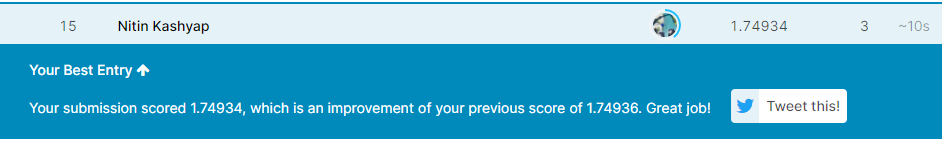

Was able to crank up the model and reduce the error again.

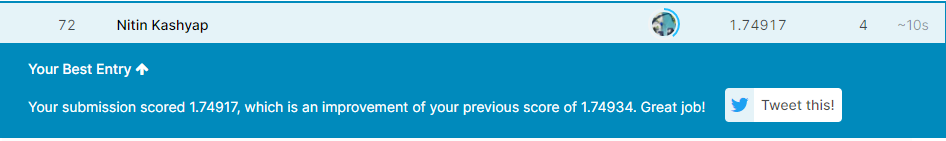

# Rerun the model and look at feature importances

I am now planning to rerun a simpler model using catboost for some iteratiosn and get a sense of the features that are most important for our model. And then rerun the optuna with the reduced number of features to get the final result

In [42]:
from sklearn.model_selection import train_test_split

data = train_test_split(train[indep_vars], train[dep_var], test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=indep_vars
)

validation_pool = Pool(
    data=X_validation, 
    label=y_validation, 
    cat_features=indep_vars
)


In [8]:
model_prev = CatBoostClassifier()
model_prev.load_model("/content/Catboost_optuna_Jun21.model")

CatBoostError: ignored

In [53]:
prev_params = model_prev.get_all_params()
model_feature = CatBoostClassifier()

model_feature.set_params(**prev_params)

In [56]:
model_feature.fit( ,  eval_set=validation_pool)

CatBoostError: ignored

USing Loss Function Change: This methodology meaures how much the loss function cahnges based on the fetaure changes. In this porcess we are training the model with the feature and then train the modle without the feature (This second precess is approximated by using we atre removing thsi feature from all the tress and avaraging the leaf values ad then saying that this would be the effect of dropping this feature from the prediction) This loss function change works well but is time-consuming. These feature importances is both positiove and negative and I will remove the features that affect the loss function negatively.


In [46]:
model_prev.get_feature_importance(train_pool, 'LossFunctionChange', prettified=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoostError: ignored

In [40]:
train_pool.get_feature_names()

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'fea